In [2]:
!pip install -r requirements.txt -q


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
from sympy import false
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed
import re
import pandas as pd
import time
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from scipy.stats import entropy

In [4]:
# load model
set_seed(42)

model_name = "Qwen/Qwen3-4B"

# load the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto", # Uses the appropriate dtype for your hardware (e.g., bfloat16, float16, float32)
    device_map="auto",   # Automatically maps the model to available devices (e.g., GPU)
    attn_implementation="eager"  # ← THIS IS REQUIRED
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [12]:
def chat(user_prompt, max_tokens=2200, temperature=0.2):
    """
    Interacts with the Qwen model, incorporating a system prompt for mathematical,
    short, and precise answers.

    Args:
        user_prompt (str): The user's input query.
        max_tokens (int): The maximum number of new tokens to generate for the response.
                          Reduced for "short and precise" answers.
        temperature (float): Controls the randomness of the generation. Lower values
                             make the output more deterministic.

    Returns:
        str: The model's generated response.
    """
    #system_prompt = "You are a highly logical and precise mathematical assistant. When asked a question, analyze it rigorously, break it down into its mathematical components, and provide the shortest, most accurate answer possible. Focus on direct calculations, definitions, or theorems without unnecessary elaboration."
    system_prompt = "You are a highly logical and precise mathematical assistant. When asked a question, provide the shortest, most accurate answer possible. Focus on direct calculations, definitions, or theorems without unnecessary elaboration."

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]

    # Apply the chat template to format the messages into a single prompt string
    # add_generation_prompt=True is crucial for chat models like Qwen to start generating
    formatted_prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    inputs = tokenizer(formatted_prompt, return_tensors="pt").to(model.device)

    # Generate the response
    output_ids = model.generate(
        **inputs,
        max_new_tokens=max_tokens,
        temperature=temperature,
        do_sample=True,
        top_p=0.95,
        pad_token_id=tokenizer.eos_token_id,
        # It's often good practice to set eos_token_id in generate for better termination
        eos_token_id=tokenizer.eos_token_id
    )

    # Decode the generated output, skipping the input part of the prompt
    response = tokenizer.decode(output_ids[0][inputs['input_ids'].shape[-1]:], skip_special_tokens=True)
    return response.strip()

def chat_with_attention(user_prompt, max_tokens=2200, temperature=0.2):
    """
    Interacts with the Qwen model and returns both the response and attention weights
    over the input prompt (not during generation).

    Args:
        user_prompt (str): The user's input query.
        max_tokens (int): Maximum number of new tokens to generate.
        temperature (float): Sampling temperature.

    Returns:
        Tuple[str, List[Tensor], List[str]]:
            - response: The generated text.
            - attentions: List of attention tensors (1 per layer).
                          Each tensor has shape (num_heads, seq_len, seq_len).
            - tokens: List of input tokens corresponding to the attention matrices.
    """
    import torch

    system_prompt = "You are a highly logical and precise mathematical assistant. When asked a question, provide the shortest, most accurate answer possible. Focus on direct calculations, definitions, or theorems without unnecessary elaboration."

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]

    formatted_prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    # Tokenize input
    inputs = tokenizer(formatted_prompt, return_tensors="pt").to(model.device)

    # Get attention weights on the input prompt
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    # Extract attention weights (list of tensors, one per layer)
    # Each has shape: (batch_size=1, num_heads, seq_len, seq_len)
    attentions = [layer_attn[0] for layer_attn in outputs.attentions]  # remove batch dim

    # Decode input tokens for labeling
    input_ids = inputs['input_ids'][0]
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Now generate the response (without attention tracking)
    output_ids = model.generate(
        **inputs,
        max_new_tokens=max_tokens,
        temperature=temperature,
        do_sample=True,
        top_p=0.95,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id
    )

    response = tokenizer.decode(output_ids[0][inputs['input_ids'].shape[-1]:], skip_special_tokens=True)

    return response.strip(), attentions, tokens

def extract_result(problem_response):
    match = re.search(r"FINAL ANSWER:\s*(\d+)", problem_response)
    if match:
        try:
            result = int(match.group(1))
        except ValueError:
            # print(f'Error while converting to int {match.group(1)}')
            result = None
    else:
        # print(f'No result found: {problem_response}')
        result = None
    return result

def extract_problem(revised_problem_response):
    revised_problem_text = ""
    match = re.search(r"(?:REVISED PROBLEM:)\s*(.*?)(?:\n\s*\n|\Z)", revised_problem_response, re.DOTALL)
    if match:
        revised_problem_text = match.group(1).strip()
        return revised_problem_text
    else:
        #print(f'No revised problem found in: {revised_problem_response}')
        return None

logging = True

def log(message, logging_once=False):
  if logging or logging_once:
    print(message)

def get_calc_prompt(problem, prompt_idx):
    # TODO: add more prompts in similar styles as the revised prompt
    calc_prompt = f"You will be given a math problem. The solution to the problem is an integer. Your task is to provide the solution. Only provide the final answer as an integer. Do not include any additional word or phrase. You final answer should start with 'FINAL ANSWER:'. Math problem: {problem}"
    return calc_prompt

def get_revise_prompt(problem, revised_answer, prompt_idx):
    revise_prompts = [
      f"You will be given a math problem. Your task is to revise the math problem so your final answer to the revised problem becomes {revised_answer}. Share only the revised Problem. The revised problem should start with 'REVISED PROBLEM:'.Math problem: {problem}",
      f"Revise the given math problem so your final answer to the revised problem becomes {revised_answer}. Share only the revised Problem. The revised problem should start with 'REVISED PROBLEM:'. Math problem: {problem}\n",
      f"Modify the given math problem so its solution is {revised_answer}. Present only the revised problem, starting with 'REVISED PROBLEM:'. Math problem: {problem}",
      f"You are tasked with altering the provided math problem. The revised problem must yield {revised_answer} as its solution. Output only the revised problem statement, ensuring it begins with 'REVISED PROBLEM:'. Math problem: {problem}",
      f"Imagine you are a problem reviser. Your goal is to rewrite the math problem so that its new solution becomes {revised_answer}. Deliver only the revised problem, starting with 'REVISED PROBLEM:'. Math problem: {problem}",
      f"Your task is to re-engineer the following math problem to produce {revised_answer} as its answer. The **only** text you should provide is the revised problem, which must start with 'REVISED PROBLEM:'. Math problem: {problem}",
      f"Your task is to revise the math problem so the final answer to the revised problem becomes {revised_answer}.First, understand the problem, identify which variables need to change to get the desired result and return the revised problem. Share only the revised Problem. The revised problem should start with 'REVISED PROBLEM:'. Math problem: {problem}"
    ]
    return revise_prompts[prompt_idx]


def check_counterfactual(problem, correct_answer, revised_answer, prompt_idx):
  attention_problem = None
  attention_revise = None
  attention_revised_problem = None
  token_problem = None
  token_revise = None
  token_revised_problem = None
  problem_prompt = get_calc_prompt(problem, 0)
  #print(problem_prompt)
  revise_prompt = get_revise_prompt(problem, revised_answer, prompt_idx)
  log("+------------- Inital Problem -------------+")
  log(problem_prompt)
  log("+---------------- Response ----------------+")
  problem_response = chat(problem_prompt)
  initial_answer = extract_result(problem_response)
  log(initial_answer)
  if initial_answer is not None and initial_answer == correct_answer:
    log("✅ Correct answer (original problem)")
    log("+------------ Revised Problem -------------+")
    log(revise_prompt)
    log("+---------------- Response ----------------+")
    revised_problem_response, attention_revise, token_revise = chat_with_attention(revise_prompt)
    log(revised_problem_response)
    revised_problem = extract_problem(revised_problem_response)
    revised_problem_prompt = get_calc_prompt(revised_problem, prompt_idx)
    log(f"Revised Problem Prompt: {revised_problem_prompt}")
    log("+------------ Revised Answer --------------+")
    revised_problem_answer = chat(revised_problem_prompt)
    extracted_revised_answer = extract_result(revised_problem_answer)
    if extracted_revised_answer is not None and extracted_revised_answer == revised_answer:
      log(f"Revised answer: {extracted_revised_answer}")
      log("✅ Correct answer (revised & original problem)")
      return True, 'CORRECT ANSWER', attention_revise, token_revise
    else:
      log(f"Revised answer: {extracted_revised_answer}")
      log("❌ Wrong answer (revised problem)")
      return False, 'WRONG REVISED ANSWER', attention_revise, token_revise
  else:
    log(f"Response: {problem_response}")
    log(f"Initial answer: {initial_answer}")
    log("❌ Wrong answer (original problem)")
    return False, 'WRONG INTIAL ANSWER', attention_revise, token_revise
  return False, 'UNKNOWN', attention_revise, token_revise

def plot_attention(attention, tokens, layer=0, head=0, max_tokens=50):
    #matrix = attention[layer][head].detach().to(torch.float32).cpu().numpy()

    # Average over all heads (shape: [num_heads, seq_len, seq_len] → [seq_len, seq_len])
    matrix = attention[layer].detach().to(torch.float32).mean(dim=0).cpu().numpy()

    import seaborn as sns
    import matplotlib.pyplot as plt

    # Trim to first `max_tokens`
    matrix = matrix[:max_tokens, :max_tokens]
    trimmed_tokens = tokens[:max_tokens]

    plt.figure(figsize=(12, 10))
    sns.heatmap(matrix, xticklabels=trimmed_tokens, yticklabels=trimmed_tokens, cmap="viridis")
    plt.title(f"Attention - Layer {layer}, Head {head}")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'./output/attention_{idx}_{reason}.png')
    plt.show()

def plot_most_relevant_attention(attention, tokens, layer=0, head=0, max_tokens=50):
    # Ensure attention is a tensor and process it
    # We are averaging over all heads as in your original modified line.
    # The shape of attention[layer] is typically [num_heads, seq_len, seq_len]
    # After mean(dim=0), matrix will be [seq_len, seq_len]
    matrix = attention[layer].detach().to(torch.float32).mean(dim=0).cpu().numpy()

    # Calculate importance scores for each token
    # A token's importance is the sum of attention it receives (column-wise sum)
    # plus the sum of attention it gives (row-wise sum).
    importance_scores = np.sum(matrix, axis=0) + np.sum(matrix, axis=1)

    # Get the indices of the top `max_tokens` most important tokens
    # Use argsort to get indices that would sort the array, then slice the last max_tokens
    # and reverse to get in descending order of importance.
    sorted_indices = np.argsort(importance_scores)[::-1]
    top_k_indices = sorted_indices[:max_tokens]

    # Sort these indices to maintain the original relative order for better visualization
    # This is important for the heatmap's axis labels to make sense.
    top_k_indices.sort()

    # Create a sub-matrix with only the most important tokens
    # Select rows and columns corresponding to the top_k_indices
    trimmed_matrix = matrix[top_k_indices][:, top_k_indices]

    # Create a list of trimmed tokens corresponding to the selected indices
    trimmed_tokens = [tokens[i] for i in top_k_indices]

    plt.figure(figsize=(12, 10))
    sns.heatmap(trimmed_matrix, xticklabels=trimmed_tokens, yticklabels=trimmed_tokens, cmap="viridis")
    plt.title(f"Attention - Layer {layer} (Averaged over Heads) - Top {max_tokens} Most Important Tokens")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'./output/attention_important_{idx}_{reason}.png')
    plt.show()

def clean_tokens(tokens):
    return [t if not t.startswith("<|") else "␣" for t in tokens]

def filter_math_tokens(tokens):
    """
    Returns indices and tokens that appear mathematically relevant.

    Args:
        tokens (List[str]): List of tokens from the tokenizer.

    Returns:
        List[int]: Indices of math-relevant tokens.
        List[str]: Corresponding tokens.
    """
    math_keywords = {
        "+", "-", "*", "/", "^", "=", "<", ">", "≤", "≥",
        "divided", "times", "integral", "derivative", "log", "ln",
        "sqrt", "π", "pi", "e", "sin", "cos", "tan",
        "sum", "∑", "∫", "mod", "=", "**", "//"
    }

    math_token_indices = []
    math_token_values = []

    for i, tok in enumerate(tokens):
        tok_clean = tok.lower().strip()

        # Match numbers or math-like patterns
        is_number = re.fullmatch(r"\d+(\.\d+)?", tok_clean) is not None
        is_operator = tok_clean in math_keywords
        is_math_word = any(kw in tok_clean for kw in math_keywords)

        if is_number or is_operator or is_math_word:
            math_token_indices.append(i)
            math_token_values.append(tokens[i])

    return math_token_indices, math_token_values

def plot_attention_math_only(attention, tokens, layer=0, head=0):
    indices, math_tokens = filter_math_tokens(tokens)

    matrix = attention[layer][head].detach().to(torch.float32).cpu().numpy()

    # Slice matrix to math-only tokens
    matrix = matrix[indices][:, indices]

    plt.figure(figsize=(14, 10))
    sns.heatmap(matrix, xticklabels=math_tokens, yticklabels=math_tokens, cmap="viridis")
    plt.title(f"Math Attention - Layer {layer}, Head {head}")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(f'./output/attention_math_{idx}_{reason}.png')
    plt.show()

def is_math_token(token):
    """Basic filter for math-related tokens."""
    math_keywords = {'+', '-', '*', '/', '=', '^', '%', 'plus', 'minus', 'divided', 'times', 'equals', 'equal'}
    return bool(re.match(r'^-?\d+(\.\d+)?$', token)) or token in math_keywords

def extract_features(attention, tokens):
    """
    Extracts interpretable attention-based and token-based features from a single example.

    Args:
        attention (list of torch.Tensor): List of attention maps per layer (shape: [heads, seq_len, seq_len])
        tokens (list of str): List of input tokens

    Returns:
        dict: Feature dictionary
    """
    features = {}
    num_tokens = len(tokens)
    math_token_indices = [i for i, tok in enumerate(tokens) if is_math_token(tok)]

    # --- Token-based features ---
    features["sequence_length"] = num_tokens
    features["num_numerical_tokens"] = sum(re.match(r'^\d+(\.\d+)?$', tok) is not None for tok in tokens)
    features["num_math_tokens"] = len(math_token_indices)
    features["math_token_ratio"] = len(math_token_indices) / num_tokens if num_tokens > 0 else 0
    features["has_equals_sign"] = "=" in tokens or "equals" in tokens

    # Select layer 0 and last layer for summaries
    attn_layer_0 = attention[0]             # shape: [heads, N, N]
    attn_layer_last = attention[-1]

    def mean_attention_to(indices, attn_layer):
        if len(indices) == 0:
            return 0.0
        # Sum attention to math tokens across all heads and from all tokens
        total = sum(attn[:, :, indices].sum().item() for attn in [attn_layer])
        return total / (attn_layer.shape[0] * attn_layer.shape[1] * len(indices))

    def mean_attention_from(indices, attn_layer):
        if len(indices) == 0:
            return 0.0
        total = sum(attn[:, indices, :].sum().item() for attn in [attn_layer])
        return total / (attn_layer.shape[0] * len(indices) * attn_layer.shape[2])

    # --- Attention features (layer 0 and last layer) ---
    features["mean_attention_to_math_tokens_0"] = mean_attention_to(math_token_indices, attn_layer_0)
    features["mean_attention_to_math_tokens_last"] = mean_attention_to(math_token_indices, attn_layer_last)

    features["mean_attention_from_math_tokens_0"] = mean_attention_from(math_token_indices, attn_layer_0)
    features["mean_attention_from_math_tokens_last"] = mean_attention_from(math_token_indices, attn_layer_last)

    # Final token attention (how much is attended to)
    final_token_index = num_tokens - 1
    final_token_attn_received = attn_layer_last[:, :, final_token_index].mean().item()
    features["final_token_attention_received"] = final_token_attn_received

    # Max attention from any math token
    if math_token_indices:
        max_attn_from_math = attn_layer_last[:, math_token_indices, :].max().item()
    else:
        max_attn_from_math = 0.0
    features["max_attention_from_math_token"] = max_attn_from_math

    # Self-attention (diagonal values)
    diag_mask = torch.eye(num_tokens).bool().to(attn_layer_0.device)
    self_attention_vals = attn_layer_0[:, diag_mask].view(attn_layer_0.shape[0], -1)  # shape: [heads, N]
    features["self_attention_ratio"] = self_attention_vals.mean().item()

    # Attention entropy (layer 0, per token) – for math tokens only
    math_indices = [i for i, token in enumerate(tokens) if is_math_token(token)]
    entropies = []

    if math_indices:
        for head in attn_layer_0:  # shape: (num_heads, seq_len, seq_len)
            for row in head:  # shape: (seq_len,)
                row_np = row.detach().cpu().to(torch.float32).numpy()
                # Select attention distribution over math tokens only
                selected = row_np[math_indices]
                # Normalize to ensure it’s a valid distribution
                selected /= selected.sum() + 1e-8
                entropies.append(entropy(selected + 1e-8))  # 1D case
        features["attention_entropy_layer0_math"] = float(np.mean(entropies))
    else:
        features["attention_entropy_layer0_math"] = float("nan")

    # Head 0: max attended token is math?
    head0_attn = attn_layer_0[0]  # shape: [N, N]
    max_targets = torch.argmax(head0_attn, dim=1).tolist()
    max_target_is_math = any(idx in math_token_indices for idx in max_targets)
    features["head0_max_attention_target_is_math"] = max_target_is_math

    return features


In [6]:
# Parameterize datapoint
filename = 'gsm8k_extended_test.csv'
train_ds = pd.read_csv(filename)
prompt_idx = 0
idx = 1


Dataset: gsm8k_extended_test.csv


+------------- Inital Problem -------------+
You will be given a math problem. The solution to the problem is an integer. Your task is to provide the solution. Only provide the final answer as an integer. Do not include any additional word or phrase. You final answer should start with 'FINAL ANSWER:'. Math problem: A robe takes 2 bolts of blue fiber and half that much white fiber.  How many bolts in total does it take?
+---------------- Response ----------------+
3
✅ Correct answer (original problem)
+------------ Revised Problem -------------+
You will be given a math problem. Your task is to revise the math problem so your final answer to the revised problem becomes 3. Share only the revised Problem. The revised problem should start with 'REVISED PROBLEM:'.Math problem: A robe takes 2 bolts of blue fiber and half that much white fiber.  How many bolts in total does it take?
+---------------- Response ----------------+
<think>
Okay, let's see. The original problem is about a robe that

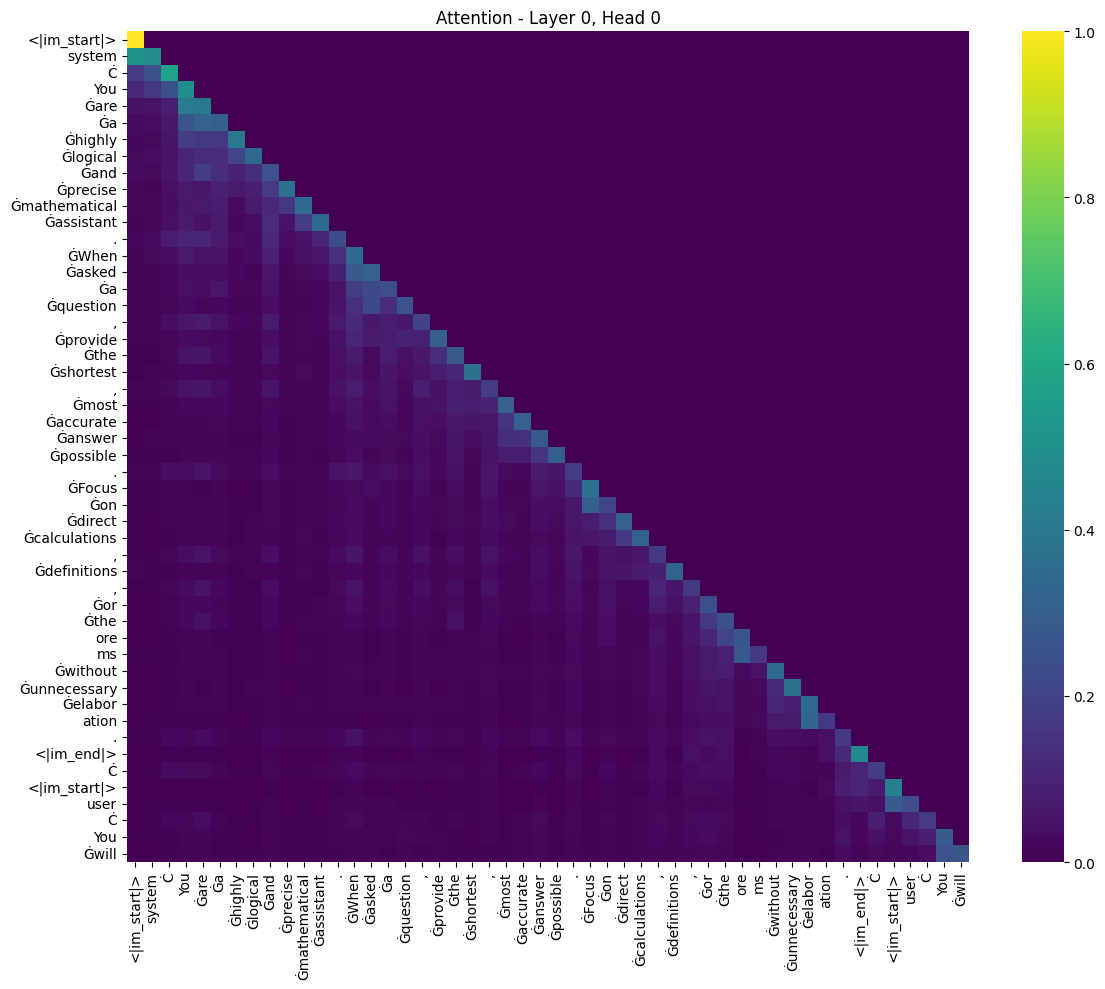

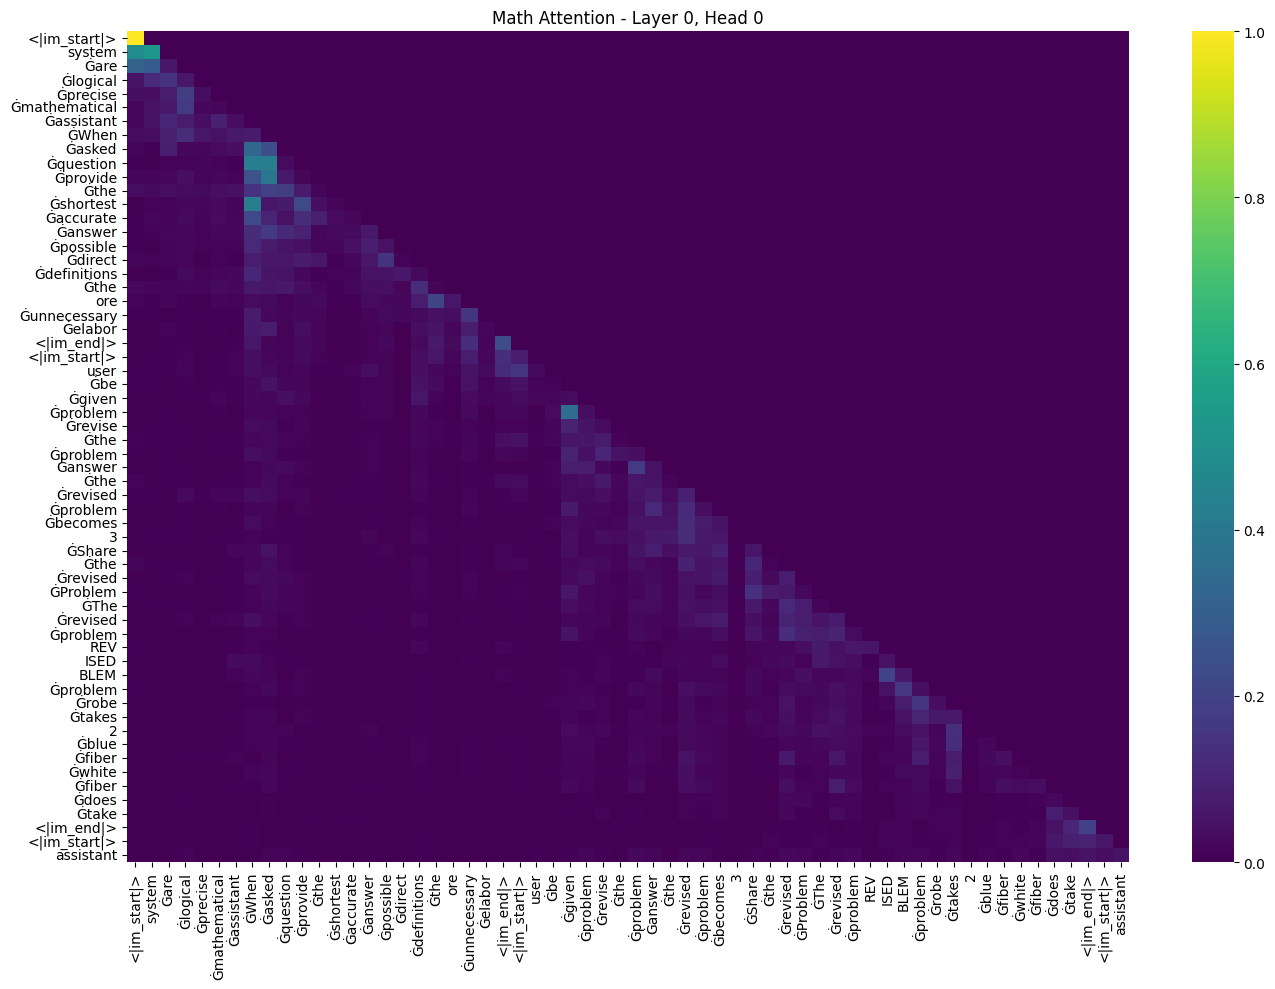

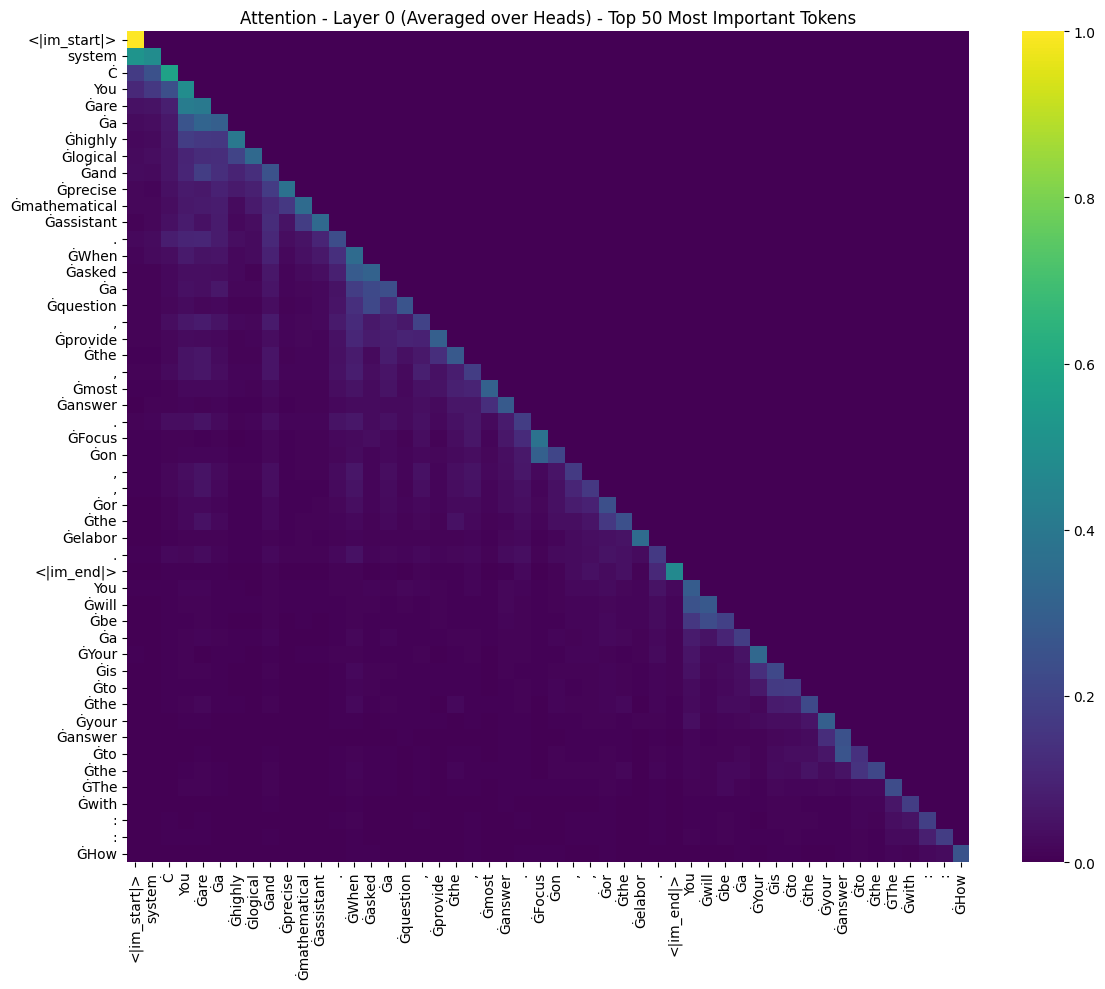

{'sequence_length': 129, 'num_numerical_tokens': 2, 'num_math_tokens': 2, 'math_token_ratio': 0.015503875968992248, 'has_equals_sign': False, 'mean_attention_to_math_tokens_0': 0.0027404312015503877, 'mean_attention_to_math_tokens_last': 0.0027101501937984497, 'mean_attention_from_math_tokens_0': 0.007751937984496124, 'mean_attention_from_math_tokens_last': 0.007751937984496124, 'final_token_attention_received': 0.001800537109375, 'max_attention_from_math_token': 0.99609375, 'self_attention_ratio': 0.271484375, 'attention_entropy_layer0_math': 0.49437540769577026, 'head0_max_attention_target_is_math': False}


In [11]:
print(f'Dataset: {filename}')
print(f'Promopt 
print(f'Dataset index: {idx}')
question = train_ds['question'][idx]
answer = train_ds['answer'][idx]
answer_int = str(answer.split('####')[1])
# Remove thounsands divider
if ',' in answer_int:
    answer_int = ''.join(digit for digit in answer_int.split(','))
answer_int = int(answer_int)
counterfactual_int = str(train_ds['revised_result'][idx])
if ',' in counterfactual_int:
    counterfactual_int = ''.join(digit for digit in counterfactual_int.split(','))
counterfactual_int = int(float(counterfactual_int))
result, reason, attention_revise, token_revise = check_counterfactual(question, answer_int, counterfactual_int, prompt_idx)
plot_attention(attention_revise, token_revise)
plot_attention_math_only(attention_revise, token_revise)
plot_most_relevant_attention(attention_revise, token_revise)
if attention_revise and token_revise:
    features = extract_features(attention_revise, token_revise)
else:
    features = { "sequence_length": 0,
                 "num_numerical_tokens": 0,
                 "num_math_tokens": 0,
                 "math_token_ratio": 0,
                 "has_equals_sign": False,
                 "mean_attention_to_math_tokens_0": 0,
                 "mean_attention_to_math_tokens_last": 0,
                 "mean_attention_from_math_tokens_0": 0,
                 "mean_attention_from_math_tokens_last": 0,
                 "final_token_attention_received": 0,
                 "max_attention_from_math_token": 0,
                 "self_attention_ratio": 0,
                 "attention_entropy_layer0_math": 0,
                 "head0_max_attention_target_is_math": False,
                 }
print(features)
